In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import re
from pandas.io.json import json_normalize

In [6]:
train_data=pd.read_csv("../input/tmdb-box-office-prediction/train.csv")
test_data=pd.read_csv("../input/tmdb-box-office-prediction/test.csv")

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [9]:
train_data.shape, test_data.shape

((3000, 23), (4398, 22))

In [10]:
pd.DataFrame(train_data.isnull().sum()).T

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,0,2396,0,7,2054,0,0,0,8,0,...,0,2,20,0,597,0,276,13,16,0


In [11]:
perc_traindata=((pd.DataFrame(train_data.isnull().sum()).T)/len(train_data))*100
perc_traindata

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,0.0,79.866667,0.0,0.233333,68.466667,0.0,0.0,0.0,0.266667,0.0,...,0.0,0.066667,0.666667,0.0,19.9,0.0,9.2,0.433333,0.533333,0.0


In [12]:
train_data.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [14]:
train_data["genres"].value_counts().unique()

array([266, 186, 108,  88,  85,  65,  47,  44,  33,  31,  30,  29,  28,
        27,  25,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [15]:
g=train_data.groupby('genres')
g

In [16]:
g.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,2988,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0096246,en,The Terror Within,Experiments in biological warfare have destroy...,1.292125,...,1/20/89,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It Wants To Get Out!,The Terror Within,"[{'id': 1299, 'name': 'monster'}, {'id': 1852,...","[{'cast_id': 4, 'character': 'Hal', 'credit_id...","[{'credit_id': '52fe45d9c3a368484e072511', 'de...",858591
2991,2992,"[{'id': 107469, 'name': 'Save The Last Dance C...",13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",NaN,tt0206275,en,Save the Last Dance,"A white midwestern girl moves to Chicago, wher...",4.794088,...,1/12/01,112.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Only Person You Need To Be Is Yourself.,Save the Last Dance,"[{'id': 4118, 'name': 'ballet dancer'}, {'id':...","[{'cast_id': 18, 'character': 'Sara Johnson', ...","[{'credit_id': '52fe4533c3a36847f80c1c6b', 'de...",91038276
2992,2993,NaN,1135654,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0015400,en,The Thief of Bagdad,A recalcitrant thief vies with a duplicitous M...,3.878515,...,3/18/24,149.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,"""Happiness Must Be Earned""",The Thief of Bagdad,"[{'id': 255, 'name': 'male nudity'}, {'id': 14...","[{'cast_id': 3, 'character': 'The Thief of Bag...","[{'credit_id': '52fe45bec3a368484e06c70b', 'de...",1213880
29

In [17]:
g.count()

,id,belongs_to_collection,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
genres,,,,,,,,,,,,,,,,,,,,,
"[{'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}]",1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,0,1,0,1,1,1
"[{'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}]",2,0,2,1,2,2,2,2,2,2,...,2,2,2,2,1,2,2,2,2,2
"[{'id': 10402, 'name': 'Music'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}]",1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"[{'id': 10402, 'name': 'Music'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}, {'id': 80, 'name': 'Crime'}]",1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"[{'id': 10402, 'name': 'Music'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[{'id': 99, 'name': 'Documentary'}, {'id': 27, 'name': 'Horror'}]",1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"[{'id': 99, 'name': 'Documentary'}, {'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}]",1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
"[{'id': 99, 'name': 'Documentary'}, {'id': 36, 'name': 'History'}]",2,0,2,1,2,2,2,2,2,2,...,2,2,2,2,1,2,1,2,2,2


In [18]:
pd.DataFrame(train_data.isnull().sum()).T

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,0,2396,0,7,2054,0,0,0,8,0,...,0,2,20,0,597,0,276,13,16,0


In [19]:
perc_traindata=((pd.DataFrame(train_data.isnull().sum()).T)/len(train_data))*100
perc_traindata

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,0.0,79.866667,0.0,0.233333,68.466667,0.0,0.0,0.0,0.266667,0.0,...,0.0,0.066667,0.666667,0.0,19.9,0.0,9.2,0.433333,0.533333,0.0


Text(0, 0.5, 'percentage with missing train data')

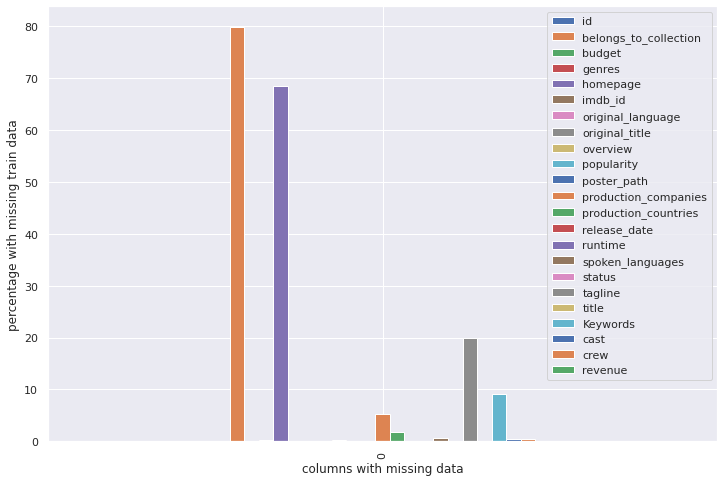

In [20]:
sns.set(rc={'figure.figsize':(12,8)})
perc_traindata.plot.bar()
plt.xlabel("columns with missing data")
plt.ylabel("percentage with missing train data")


In [21]:
''' dropin of column if NAN value >60'''

' dropin of column if NAN value >60'

In [22]:
train_data.drop(columns=['belongs_to_collection', 'homepage'], axis=1, inplace=True)

In [23]:
train_data.columns

Index(['id', 'budget', 'genres', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue'],
      dtype='object')

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3000 non-null   int64  
 1   budget                3000 non-null   int64  
 2   genres                2993 non-null   object 
 3   imdb_id               3000 non-null   object 
 4   original_language     3000 non-null   object 
 5   original_title        3000 non-null   object 
 6   overview              2992 non-null   object 
 7   popularity            3000 non-null   float64
 8   poster_path           2999 non-null   object 
 9   production_companies  2844 non-null   object 
 10  production_countries  2945 non-null   object 
 11  release_date          3000 non-null   object 
 12  runtime               2998 non-null   float64
 13  spoken_languages      2980 non-null   object 
 14  status                3000 non-null   object 
 15  tagline              

In [25]:
'''removing columns which will not affect the data'''

'removing columns which will not affect the data'

In [26]:
train_data.drop(columns=['imdb_id','poster_path', 'tagline','overview','original_title','Keywords', 'crew'], axis=1, inplace=True)

In [27]:
train_data.shape

(3000, 14)

In [28]:
train_data.dtypes

id                        int64
budget                    int64
genres                   object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
title                    object
cast                     object
revenue                   int64
dtype: object

In [29]:
pd.DataFrame(test_data.isnull().sum()).T

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,0,3521,0,16,2978,0,0,0,14,0,...,102,1,4,42,2,863,3,393,13,22


In [30]:
perc_testdata=((pd.DataFrame(test_data.isnull().sum()).T)/len(test_data))*100
perc_testdata

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,0.0,80.059118,0.0,0.363802,67.712597,0.0,0.0,0.0,0.318327,0.0,...,2.319236,0.022738,0.09095,0.95498,0.045475,19.622556,0.068213,8.93588,0.295589,0.500227


Text(0, 0.5, '% of missing data')

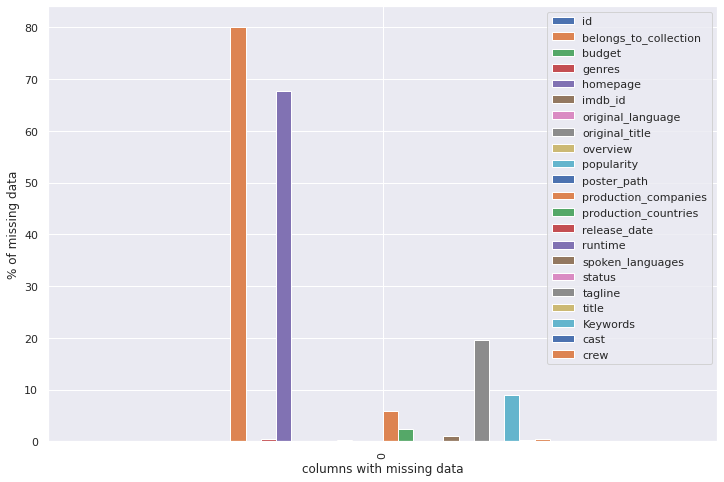

In [31]:
sns.set(rc={'figure.figsize':(12,8)})
perc_testdata.plot.bar()
plt.xlabel("columns with missing data")
plt.ylabel("% of missing data")

In [32]:

test_data.drop(columns=['imdb_id','poster_path','tagline','overview','original_title','crew','Keywords'], axis=1, inplace=True)

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   original_language      4398 non-null   object 
 6   popularity             4398 non-null   float64
 7   production_companies   4140 non-null   object 
 8   production_countries   4296 non-null   object 
 9   release_date           4397 non-null   object 
 10  runtime                4394 non-null   float64
 11  spoken_languages       4356 non-null   object 
 12  status                 4396 non-null   object 
 13  title                  4395 non-null   object 
 14  cast                   4385 non-null   object 
dtypes: f

In [34]:
test_data.shape

(4398, 15)

Let's first extract the data from the columns which have JSON Objects

GENRE

In [35]:
#extract only genres column from the train dataset and create new dataset of it which contains only genres column

In [36]:
new=train_data.loc[:,["genres"]]
new["genres"]=train_data["genres"].fillna("None");
new["genres"].head(5)

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [37]:
def extract_genres(row):
    if row=="None":
        return['None']
    else:
        results=re.findall(r"'name':'(\w+\s?\w+)'", row)
        return results 

In [38]:
new["genres"]=new["genres"].apply(extract_genres)
new["genres"].head(10)

0    []
1    []
2    []
3    []
4    []
5    []
6    []
7    []
8    []
9    []
Name: genres, dtype: object

In [39]:
def extract_genres(row):
    if row == "None":
        return ['None']
    else:
        results = re.findall(r"'name': '(\w+\s?\w+)'", row)
        return results